# CS5100 Final Project

Name: Arjun Patel


## Prerequisites

1. Here you will need to create a federal reserve account to recieve an API code
    https://fredaccount.stlouisfed.org/apikeys

2. You will also need to install yFinance
    pip install yfinance --upgrade --no-cache-dir
    
    or if you have python3
    pip3 install yfinance --upgrade --no-cache-dir

3. You will also need to install matplotlib
    pip install -U pip
    pip install -U matplotlib

    or if you have python3
    pip3 install -U pip
    pip3 install -U matplotlib  

4. You will also need to install numpy
    pip install numpy

    or if you have python3
    pip3 install numpy

5. You will also need to install pandas
    pip install pandas

    or if you have python3
    pip3 install pandas


## Problem

The problem I am trying to solve is when you should buy QQQ stock on a given day. What my program will learn is based on price movement, weekly economic data ("WEI"), and interest rates ("DFF") when should we buy QQQ on a given day?

## Data

I have 2 main datasources. One is from yahoo finance and the other is from the Federal Reserve.

Yahoo finance gets stock and financial data from ICE data sources, which is a leading company that provides real time financial market data. Even though this data is avaliable on many sources, yahoo finance is able to store its data on their website and people are able to access the API for free through yfinance. After you download yfinance, you can access all data for any stock that is on yahoo finance. In yfinance, the data is saved in a dataframe, which is convenient as the data structure is organized well

The Federal Reserve is a government entity that publishes information on economic data. This is the most reliable source of information when it comes to economic data because the Federal Reserve has all information pertaining to the economic state of the United States that they publish. Essentially, the Federal Reserve is the source of truth. The Federal Reserve has a website called FRED where they save all reports ever reported to the public. They also save all the data on their website for anyone to access. However, if you are looking to access the information from an API, you will need to create an account and request information. Once you have access to their API, you will notice their data structure for their reports are also in a dataframe

Below is more information on how to combine both datasets and clean it through python

## Cleaning the Data

HERE IS THE GRAPH OF QQQ


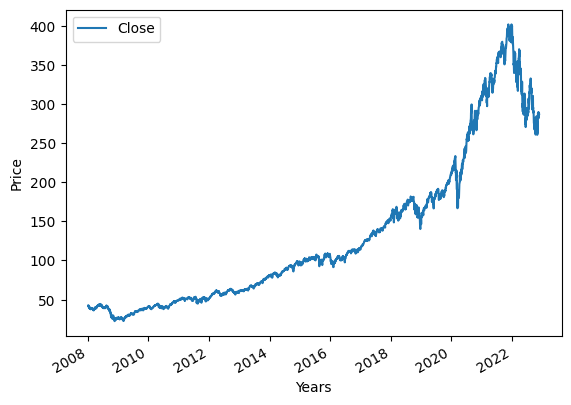

Here we want to visualize whether if the day was up or down
                           Actual_Close  Target
Date                                           
2008-01-07 00:00:00-05:00     42.331455     NaN
2008-01-08 00:00:00-05:00     41.232967     0.0
2008-01-09 00:00:00-05:00     42.111752     1.0
2008-01-10 00:00:00-05:00     42.173267     1.0
2008-01-11 00:00:00-05:00     41.347202     0.0
Lets see what our data looks like now
                           Actual_Close  Target      Close       High  \
Date                                                                    
2008-01-08 00:00:00-05:00     41.232967     0.0  42.331455  42.709336   
2008-01-09 00:00:00-05:00     42.111752     1.0  41.232967  42.849947   
2008-01-10 00:00:00-05:00     42.173267     1.0  42.111752  42.146904   
2008-01-11 00:00:00-05:00     41.347202     0.0  42.173267  42.542359   
2008-01-14 00:00:00-05:00     42.067814     1.0  41.347202  41.979934   

                                 Low       Open       

In [275]:
# Lets import our fredapi, pandas, and timedelta
import fredapi as fa
import pandas as pd
from datetime import timedelta

# Here is our FRED API key
fred = fa.Fred('c0fec4be089bf8ebac233c2103bffee5')

# Lets import yfinance and yahoo
import yfinance as yf

# Lets import matplotlib
import matplotlib.pyplot as plt

# Bring up the ticket QQQ
QQQ = yf.Ticker("QQQ")

# Here we want to match the start date and end date based on the 
# timeline the federal reserve has for the weekly economic index (WEI)
QQQ_history = QQQ.history(start="2008-01-05", end ="2022-11-26")

# Visualize Data for QQQ to understand what our program is looking at
# and understand what our models are looking at (double check to make
# sure data looks correct as well)
QQQ_history.plot.line(y='Close', use_index = True)
plt.ylabel('Price')
plt.xlabel('Years')
print("HERE IS THE GRAPH OF QQQ")
plt.show()

# Here we want to see the close price. This is what our program
# will use for the price to analyze the data 
# The reason why we want close price instead of open is because 
# we want to see if the day will be up or down at the end of the day.
# When the market opens, it wont usually change significantly from the last
# close price
data = QQQ_history[["Close"]]

# Lets rename the column close to Actual_Close
# This way we know this is the real close
data = data.rename(columns = {'Close': 'Actual_Close'})

# Here we want to compare previous day and next day to see if the price went up
# If it went up, write 1
# If it went down, write 0
# Here we want to create a target. The target tells us whether the day was up or down.
# We are rolling the data by 2 so that way we compare to close price from a previous day
# and the next day
data["Target"] = QQQ_history.rolling(2).apply(lambda x: x.iloc[1]>x.iloc[0])["Close"]

# Lets visualize what we have so far to make sure we are on track
print("Here we want to visualize whether if the day was up or down")
print(data.head(5))

# NOTE: This is important. Here we want to shift the data by 1 day. This is because when we are 
# analyzing stock prices we have to take past data and not the current data so we need to shift 
# the data by one so that our program knows we are taking past data to predict the future. 
QQQ_copy = QQQ_history.copy()
QQQ_shifted = QQQ_copy.shift(1)

# Here we are creating our data and variables we are analyzing
# we will use to train our model
# We will also use the shifted data to make sure we are using past data
# We also want to exclude the first index as its N/A in the target
variables = ["Close","High","Low","Open","Volume"]
data = data.join(QQQ_shifted[variables]).iloc[1:]

# Lets visualize what we have so far
print("Lets see what our data looks like now")
print(data.head(5))

# Here we want to cleanup the WEI data. Each report comes out
# on saturday, which means if we want to join it with the stock
# data for QQQ from yfinance we need to shift it to monday when the market opens
# NOTE: This is important. There will be some trading days that are not on monday,
# which means that some reports will be excluded
FRED_WEI = fred.get_series('WEI')
for key in FRED_WEI.keys():
    FRED_WEI[key + timedelta(days=2)] = FRED_WEI[key]
    del FRED_WEI[key]

# We will need to create a name for this dataframe
FRED_WEI.name = "WEI"

# This is the interest rates that are reported weekly (on thursdays)
# wich means we do not need to change this data
FRED_DFF = fred.get_series('DFF')

# We will need to create a name for this dataframe
FRED_DFF.name = "DFF"

# Lets make the indexs for both data sources the same so that 
# we can join on index
FRED_WEI.index = FRED_WEI.index.strftime('%m/%d/%Y')
FRED_DFF.index = FRED_DFF.index.strftime('%m/%d/%Y')
data.index = data.index.strftime('%m/%d/%Y')

# We can now join QQQ and WEI data
data = data.join(FRED_WEI)

# We can now join data and interest rates
data = data.join(FRED_DFF)

# Here we want to replace all N/A with 0
data = data.fillna(0)

# Lets update the variables with WEI
variables = ["Close","High","Low","Open","Volume","WEI","DFF"]


# Here we want to create more predictors for our models to make them more accurate

# Lets get weekly, quartly, and annual means
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

# Lets look at the weekly trend based on target
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

# Lets create ratios for weekly, quartly, and annual means compared to 
# the closing price
data["Weekly Mean"] = weekly_mean["Close"] / data["Close"]
data["Quarterly Mean"] = quarterly_mean["Close"] / data["Close"]
data["Annual Mean"] = annual_mean["Close"] / data["Close"]

# Lets create annual ratios between annual and weekly/quarterly 
data["Annual Weekly Mean"] = data["Annual Mean"] / data["Weekly Mean"]
data["Annual Quarterly Mean"] = data["Annual Mean"] / data["Quarterly Mean"]
data["Weekly Trend"] = weekly_trend

# Lets get range of day and volatility of day
data["Daily Range"] = data["Close"] - data["Open"]
data["Daily Volatility"] = data["High"] - data["Low"]


# Lets add all of these columns to our variables
full_variables = variables + ["Weekly Mean", "Quarterly Mean", "Annual Weekly Mean", "Annual Quarterly Mean", "Weekly Trend", "Daily Range", "Daily Volatility"]




# Lets see the final result
print("This is the final table we will use")
print(data)


## Learning Model, Tuning, and Feature Extraction

Here we will look at 4 different models

In [276]:
# Import sklearn RandomForestClassifier and reports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

# Here we want to select the data. Its important to not include the last 3 years
# so that we can use the last 3 years to backtest our results
data_train = data.iloc[:-1095]

# Here we want to test the last 3 years
data_test = data.iloc[-1095:]

# Here we want to develop our model
# Depending on the data, we want to play around with:
# n_estimators: The number of trees in the forest
# min_samples_split: The minimum number of samples required to split an internal node
# NOTE: Random_state allows us to make sure we arent running the same 
# scenario each time we run our code
# After tunning the model, I found (n_estimators= 825, min_samples_split= 1000, random_state =1)
# has the best performance
model_RandomForestClassifier = RandomForestClassifier(n_estimators= 825, min_samples_split= 1000, random_state =1)

# Here we want to fit our model on our training data (Variables vs. Target)
model_RandomForestClassifier.fit(data_train[variables], data_train["Target"])

# Here we want to predict our data using our test dates
predictions_RandomForestClassifier = model_RandomForestClassifier.predict(data_test[variables])

# Here we want to convert it back to a series
predictions_RandomForestClassifier = pd.Series(predictions_RandomForestClassifier, index=data_test.index)

# Lets print our classification report and our precision score to see our accuracy
print(classification_report(data_test["Target"], predictions_RandomForestClassifier)) 
print("Here is our accuracy report: ", precision_score(data_test["Target"], predictions_RandomForestClassifier))


              precision    recall  f1-score   support

         0.0       0.44      0.91      0.59       481
         1.0       0.58      0.09      0.16       614

    accuracy                           0.45      1095
   macro avg       0.51      0.50      0.38      1095
weighted avg       0.52      0.45      0.35      1095

Here is our accuracy report:  0.5757575757575758


In [277]:
# Import Logistic Regression and reports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Here we want to select the data. Its important to not include the last 3 years
# so that we can use the last 3 years to backtest our results
data_train = data.iloc[:-1095]

# Here we want to test the last 3 years
data_test = data.iloc[-1095:]

# Here we want to create our logistic regression model
# We can use max_iter to tune our model
# I found (max_iter=10000, random_state = 1)
# has the best performance
model_LogisticRegression = LogisticRegression(max_iter=10000, random_state = 1)

# Here we want to fit our model on our training data (Variables vs. Target)
model_LogisticRegression.fit(data_train[variables], data_train["Target"])

# Here we want to predict our data using our test dates
predictions_LogisticRegression = model_LogisticRegression.predict(data_test[variables])

# Here we want to convert it back to a series
predictions_LogisticRegression = pd.Series(predictions_LogisticRegression, index=data_test.index)

# Lets print our classification report and our precision score to see our accuracy
print(classification_report(data_test["Target"], predictions_LogisticRegression)) 
print("Here is the accuracy score: ", accuracy_score(data_test["Target"], predictions_LogisticRegression))



              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       481
         1.0       0.56      1.00      0.72       614

    accuracy                           0.56      1095
   macro avg       0.28      0.50      0.36      1095
weighted avg       0.31      0.56      0.40      1095

Here is the accuracy score:  0.5607305936073059


/Users/arjunpatel/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arjunpatel/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arjunpatel/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [278]:
# Import GaussianNB Regression and reports
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Here we want to select the data. Its important to not include the last 3 years
# so that we can use the last 3 years to backtest our results
data_train = data.iloc[:-1095]

# Here we want to test the last 3 years
data_test = data.iloc[-1095:]

# Here we want to create our model
# NOTE: There are not any parameters we can put to improve GaussianNB
model_GaussianNB = GaussianNB()

# Here we want to fit our model on our training data (Variables vs. Target)
model_GaussianNB = model_GaussianNB.fit(data_train[variables], data_train["Target"])

# Here we want to predict our data using our test dates
predictions_GaussianNB = model_GaussianNB.predict(data_test[variables])

# Here we want to convert it back to a series
predictions_GaussianNB = pd.Series(predictions_GaussianNB, index=data_test.index)

# Lets print our classification report and our precision score to see our accuracy
print(classification_report(data_test["Target"], predictions_GaussianNB)) 
print("Here is the accuracy score: ", accuracy_score(data_test["Target"], predictions_GaussianNB))



              precision    recall  f1-score   support

         0.0       0.55      0.01      0.02       481
         1.0       0.56      0.99      0.72       614

    accuracy                           0.56      1095
   macro avg       0.55      0.50      0.37      1095
weighted avg       0.55      0.56      0.41      1095

Here is the accuracy score:  0.5616438356164384


In [279]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Here we want to select the data. Its important to not include the last 3 years
# so that we can use the last 3 years to backtest our results
data_train = data.iloc[:-1095]

# Here we want to test the last 3 years
data_test = data.iloc[-1095:]

# Here we want to create our model
# We want to increase min_samples_leaf to improve accuracy
# We want a random state to make sure we arent running same scenario each time
# In backtesting, we will see this prints 0 for some reason (not sure as to why)
# I found (min_samples_split = 1000, random_state = 1)
# to be the best
model_DecisionTreeClassifier = DecisionTreeClassifier(min_samples_split = 1000, random_state = 1)

# Here we want to fit our model on our training data (Variables vs. Target)
model_DecisionTreeClassifier = model_DecisionTreeClassifier.fit(data_train[variables], data_train["Target"])

# Here we want to predict our data using our test dates
predictions_DecisionTreeClassifier = model_DecisionTreeClassifier.predict(data_test[variables])

# Here we want to convert it back to a series
predictions_DecisionTreeClassifier = pd.Series(predictions_DecisionTreeClassifier, index=data_test.index)

# Lets print our classification report and our precision score to see our accuracy
print(classification_report(data_test["Target"], predictions_DecisionTreeClassifier)) 
print("Here is the accuracy score: ", accuracy_score(data_test["Target"], predictions_DecisionTreeClassifier))


              precision    recall  f1-score   support

         0.0       0.44      0.96      0.60       481
         1.0       0.59      0.04      0.08       614

    accuracy                           0.45      1095
   macro avg       0.51      0.50      0.34      1095
weighted avg       0.52      0.45      0.31      1095

Here is the accuracy score:  0.4465753424657534


In [280]:
# Here we want to create our backtest function
# NOTE: Backtesting is an important part of algorithmic trading
# In order for us to backtest our model appropriately, we will 
# take a part of our data and let it learn over time
# This is extremely important because we should test the performance
# over time and not take a set period to predict an x amount of the remaining
# period

# we take in:
# - data: This is the data we are testing 
# - model: This is the model we trained
# - predictors: These are the predictors what we are looking at
# - start: Start training with the first number of days
# - step: Step by the next number of days

# The whole purpose of backtesting is to understand how our machine learning model
# performs over time. As it collects more data, is it becoming more accurate or less
# accurate?
def backtest(data, model, variables, start = 1000, step = 30):
        
        # Here we want to store a list of our results
        predictions_list = []

        # for day in range(where we want to start in the data, we want to stop at the number of rows within 
        # the data, and the number of days we want to step the data)
        for day in range(start, data.shape[0], step):

            # Lets train the data by the first index to day assigned
            train = data.iloc[0:day].copy()
            
            # Lets test the data from day assigned to the step
            test = data.iloc[day:(day+step)].copy()

            # lets fit our model with the train data and train target
            model.fit(train[variables], train["Target"])

            # Lets predict the probability of our model by taking the probability 
            # QQQ will be up. [:,1] takes all the probability values QQQ will go up on a given
            # day
            probability_values = model.predict_proba(test[variables])[:,1]

            # Here we need to take the predicted values and convert them to a series
            probability_values = pd.Series(probability_values, index=test.index)

            # Here we want to say:
            # Buy when there is a probability higher than 60%
            # Dont buy when there is a probability lower than or equal to 60%
            probability_values[probability_values > .60] = 1
            probability_values[probability_values <= .60] = 0

            # Here we want to combine the data 
            combined = pd.concat({"Target": test["Target"], "Predictions": probability_values}, axis=1)

            # Lets add the data to the predictions list
            predictions_list.append(combined)

        # Lets concat all the values in the list
        predictions = pd.concat(predictions_list)


        return predictions

# Lets use our backtest data to test our model
predictions_RandomForestClassifier = backtest(data.iloc[365:], model_RandomForestClassifier, full_variables)
predictions_LogisticRegression = backtest(data.iloc[365:], model_LogisticRegression,full_variables)
predictions_DecisionTreeClassifier = backtest(data.iloc[365:], model_DecisionTreeClassifier,full_variables)
predictions_GaussianNB = backtest(data.iloc[365:], model_GaussianNB,full_variables)


# Lets see the precision of our backtest compared to our model
print("Here is our precision score (RandomForestClassifier): " , precision_score(predictions_RandomForestClassifier["Target"], predictions_RandomForestClassifier["Predictions"]))
print("Here is our precision score (LogisticRegression): " , precision_score(predictions_LogisticRegression["Target"], predictions_LogisticRegression["Predictions"]))
print("Here is our precision score (DecisionTreeClassifier): " , precision_score(predictions_DecisionTreeClassifier["Target"], predictions_DecisionTreeClassifier["Predictions"]))
print("Here is our precision score (GaussianNB): " , precision_score(predictions_GaussianNB["Target"], predictions_GaussianNB["Predictions"]))


# Lets see the value counts for our predictions
print(predictions_RandomForestClassifier["Predictions"].value_counts())

# Lets print the final data to check the data
final_data = data.iloc[-1095:].join(predictions_RandomForestClassifier["Predictions"])
print(final_data)

# Takes around 7m 22s

# Finalizing Our Model

Based on our data above, the Random Forest Classifier outperformed all the other models in the backtest, which means moving forward we should use this model to create our trading algorithm

## Visuals

Below, generate the visuals that will explain the results you are getting and show what you hoped to learn from the data.

[Text(0.375, 0.9642857142857143, 'X[3] <= 37.779\ngini = 0.491\nsamples = 2086\nvalue = [1458, 1912]'),
 Text(0.25, 0.8928571428571429, 'gini = 0.325\nsamples = 56\nvalue = [19, 74]'),
 Text(0.5, 0.8928571428571429, 'X[3] <= 392.254\ngini = 0.493\nsamples = 2030\nvalue = [1439, 1838]'),
 Text(0.375, 0.8214285714285714, 'X[13] <= 14.596\ngini = 0.492\nsamples = 2016\nvalue = [1422, 1834]'),
 Text(0.25, 0.75, 'X[7] <= 0.968\ngini = 0.491\nsamples = 2008\nvalue = [1409, 1832]'),
 Text(0.125, 0.6785714285714286, 'gini = 0.448\nsamples = 40\nvalue = [45, 23]'),
 Text(0.375, 0.6785714285714286, 'X[10] <= 1.11\ngini = 0.49\nsamples = 1968\nvalue = [1364, 1809]'),
 Text(0.25, 0.6071428571428571, 'X[4] <= 12545750.0\ngini = 0.489\nsamples = 1926\nvalue = [1321, 1788]'),
 Text(0.125, 0.5357142857142857, 'gini = 0.257\nsamples = 18\nvalue = [28, 5]'),
 Text(0.375, 0.5357142857142857, 'X[5] <= -2.34\ngini = 0.487\nsamples = 1908\nvalue = [1293, 1783]'),
 Text(0.25, 0.4642857142857143, 'gini = 0.07

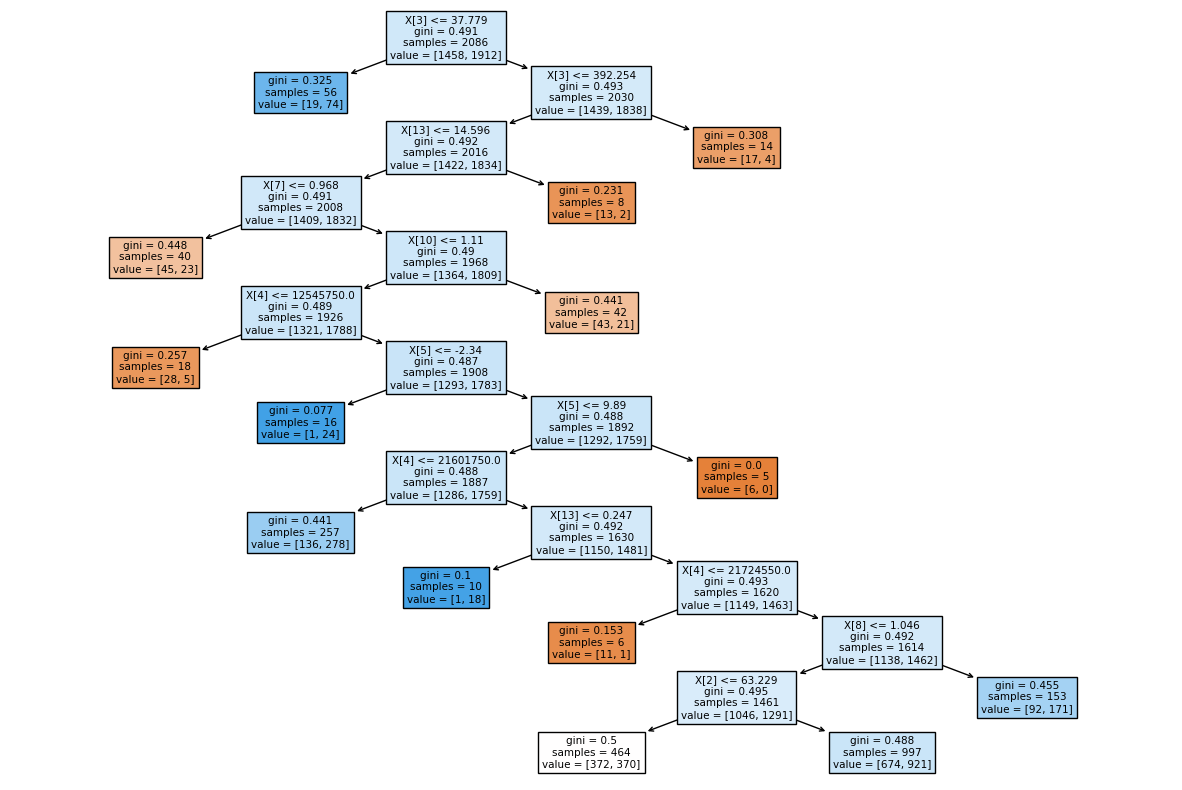

In [ ]:
# Lets visualize Random Forest
from sklearn.tree import export_graphviz
from sklearn import tree

# Here we can look at any tree
Analyze_Estimator = 20

# Lets create size and plot the tree
plt.figure(figsize=(15,10))
tree.plot_tree(model_RandomForestClassifier.estimators_[Analyze_Estimator], filled=True)


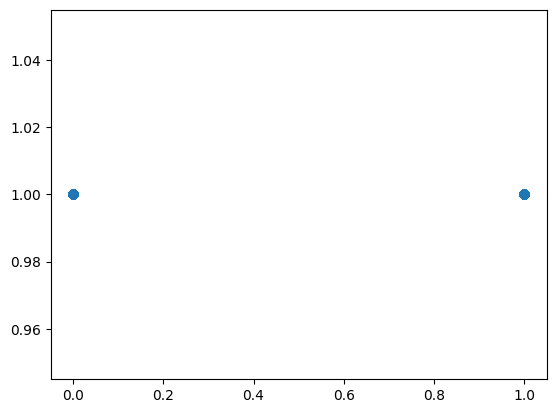

In [ ]:
# Import Logistic Regression and reports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Here we want to select the data. Its important to not include the last 3 years
# so that we can use the last 3 years to backtest our results
data_train = data.iloc[:-1095]

# Here we want to test the last 3 years
data_test = data.iloc[-1095:]

# Here we want to create our logistic regression model
# We can use max_iter to tune our model
# I found (max_iter=10000, random_state = 1)
# has the best performance
model_LogisticRegression = LogisticRegression(max_iter=10000, random_state = 1)

# Here we want to fit our model on our training data (Variables vs. Target)
model_LogisticRegression.fit(data_train[variables], data_train["Target"])

# Here we want to predict our data using our test dates
predictions_LogisticRegression = model_LogisticRegression.predict(data_test[variables])

# Here we want to convert it back to a series
predictions_LogisticRegression = pd.Series(predictions_LogisticRegression, index=data_test.index)

plt.scatter(data_test["Target"],predictions_LogisticRegression)
plt.show()




[Text(0.5, 0.9642857142857143, 'X[4] <= 12545750.0\ngini = 0.493\nsamples = 3370\nvalue = [1483, 1887]'),
 Text(0.375, 0.8928571428571429, 'gini = 0.337\nsamples = 28\nvalue = [22, 6]'),
 Text(0.625, 0.8928571428571429, 'X[0] <= 396.005\ngini = 0.492\nsamples = 3342\nvalue = [1461, 1881]'),
 Text(0.5, 0.8214285714285714, 'X[5] <= -3.595\ngini = 0.492\nsamples = 3330\nvalue = [1450, 1880]'),
 Text(0.375, 0.75, 'gini = 0.219\nsamples = 24\nvalue = [3, 21]'),
 Text(0.625, 0.75, 'X[13] <= 15.427\ngini = 0.492\nsamples = 3306\nvalue = [1447, 1859]'),
 Text(0.5, 0.6785714285714286, 'X[7] <= 1.065\ngini = 0.492\nsamples = 3297\nvalue = [1439, 1858]'),
 Text(0.375, 0.6071428571428571, 'X[3] <= 35.08\ngini = 0.492\nsamples = 3286\nvalue = [1439, 1847]'),
 Text(0.25, 0.5357142857142857, 'gini = 0.346\nsamples = 36\nvalue = [8, 28]'),
 Text(0.5, 0.5357142857142857, 'X[10] <= 1.012\ngini = 0.493\nsamples = 3250\nvalue = [1431, 1819]'),
 Text(0.375, 0.4642857142857143, 'X[1] <= 37.283\ngini = 0.491

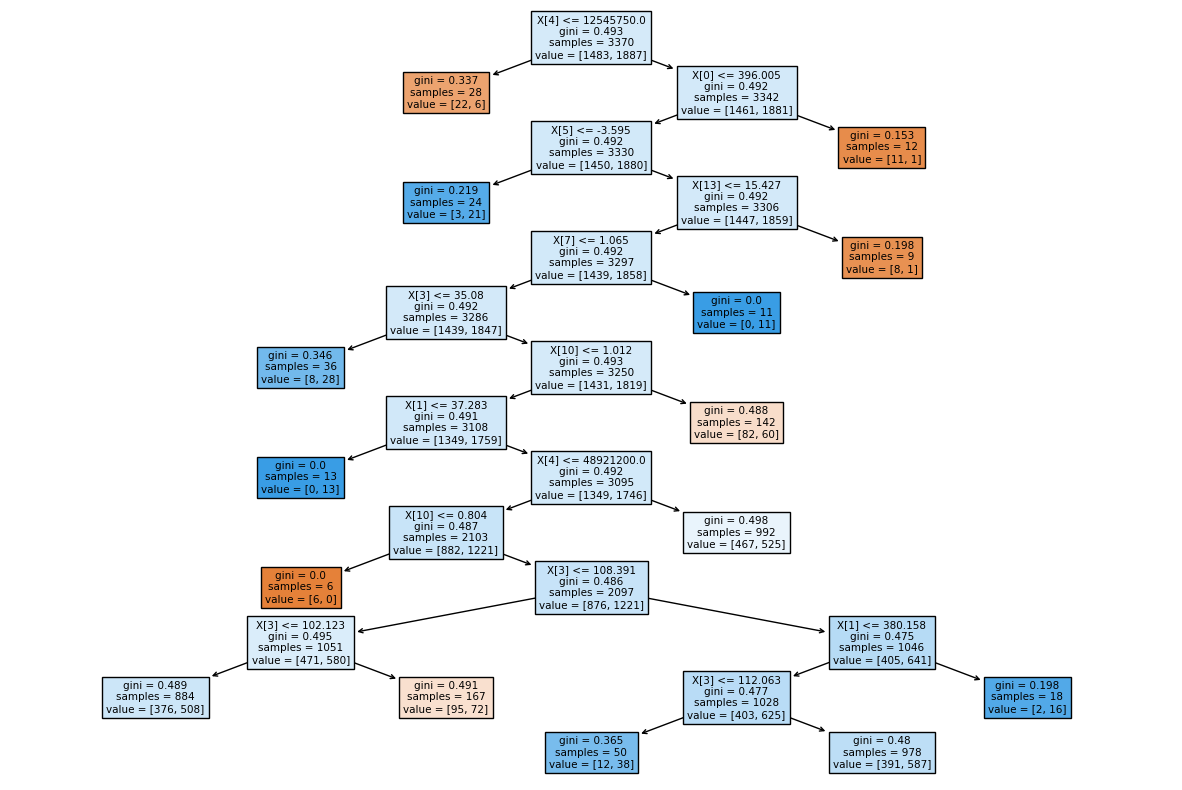

In [ ]:
# Lets visualize Decision Tree Classifier

plt.figure(figsize=(15,10))
tree.plot_tree(model_DecisionTreeClassifier,filled=True)

In [ ]:
# Here we can test to see if we made profits based on our variables

# Record sum of cash
sum_1 = 0

# Input amount of cash we have
total_cash_1 = 10000

# Iterate through data
for value in range(0, len(final_data)):

    # Record open and close
    open = final_data['Open'][value]
    close = final_data["Close"][value]

    # If prediction states we think QQQ will be up
    # Lets buy the open and sell on the close
    if final_data["Predictions"][value] == 1:
        total_shares = total_cash_1/open
        profit = (close-open)*total_shares
        # print("Total profit on trade: " ,profit)
        sum_1 += profit
        total_cash_1 = total_cash_1 + profit
        # print("Total cash: ", total_cash_1)

print("FINISHED!")
print("Total profits made: ", sum_1)
print("Total cash:", total_cash_1)


FINISHED!
Total profits made:  -7720.564400163526
Total cash: 2279.43559983648


In [ ]:
# Lets see if we can adjust our strategy to make sure we make a profit

# Let record sum of profit
sum_2 = 0

# Lets start off with an ammount of cash
total_cash_2 = 10000

# Lets record the last buy price
last_buy_price = 0

# Lets record the total shares we have
total_shares_hold = 0

# Lets look at the status of the trade
status_of_trade = ""

# Lets record the original total cash
total_original = total_cash_2

# Lets invest 50% of our cash for each trade
total_invest = .5

# Lets invest 5% each time we are in hold
total_dollar_cost_average = .05

# Iterate through data
for value in range(0,len(final_data)):

    # Look at open and close 
    open = final_data['Open'][value]
    close = final_data["Close"][value]
    #print("Open price: ", open,
    #"Closing Price: ", close,
    #"Price Change: ", close-open)

    # If we think QQQ will go up
    if final_data["Predictions"][value] == 1:

        # If we make a profit on same day, lets sell
        if close-open > 0 and status_of_trade == "":
            total_shares = (total_cash_2*total_invest) / open
            #print("SAME DAY SELL")
            #print("TOTAL PROFIT ON TRADE: ", (close-open)*total_shares)
            total_cash_2 = total_cash_2 + (close-open)*total_shares
            #print("New Cash Balance: ", total_cash_2)
            sum_2 += (close-open)*total_shares
            last_buy_price = 0

        # If we cant make a profit on same day, lets hold the position
        if close-open <= 0 and last_buy_price == 0:
            #print("HOLD")
            status_of_trade = "HOLD"
            last_buy_price = open
            # print("LAST BUY PRICE = ", last_buy_price)
            total_shares_hold = (total_cash_2*total_invest) / open
            total_cash_2 = total_cash_2 - (total_cash_2*total_invest)
            #print("Total shares held (start): ", total_shares_hold)
            #print("New Cash Balance: ", total_cash_2)
        
        # If the next day the price is below the last buy price, lets invest 5%
        if close-last_buy_price <= 0 and status_of_trade == "HOLD":
            #print("Invest 5% (1)")
            # print("LAST BUY PRICE = ", last_buy_price)
            total_shares_hold += (total_cash_2*total_dollar_cost_average) / close
            total_cash_2 = total_cash_2 - (total_cash_2*total_dollar_cost_average)
            # print("Total invested = ", total_shares_hold*close)
            #print("Total shares held (adding): ", total_shares_hold)
            #print("New Cash Balance: ", total_cash_2)

        # If close price is greater than last buy price, lets sell for a profit
        if close-last_buy_price > 0 and status_of_trade == "HOLD":
            #print("SELL HOLDING (1)")
            #print("TOTAL PROFIT ON TRADE: ", ((close-last_buy_price)*total_shares_hold))
            total_cash_2 = total_cash_2 + (close*total_shares_hold)
            #print("New Cash Balance: ", total_cash_2)
            sum_2 += (close-last_buy_price)*total_shares_hold
            total_shares_hold = 0
            last_buy_price = 0
            status_of_trade = ""
    
    # If we think QQQ is going to go down
    if final_data["Predictions"][value] == 0:

        # Lets continue to invest 5%
        if close-last_buy_price <= 0 and status_of_trade == "HOLD":
            # print("Invest 5% (0)")
            total_shares_hold += (total_cash_2*total_dollar_cost_average) / close
            total_cash_2 = total_cash_2 - (total_cash_2*total_dollar_cost_average)
            #print("Total shares held (adding): ", total_shares_hold)
            #print("New Cash Balance: ", total_cash_2)

        # If the close price is higher than the last buy price, lets sell for a profit
        if close-last_buy_price > 0 and status_of_trade == "HOLD": 
            # print("SELL HOLDING (0)")
            #print("TOTAL PROFIT ON TRADE: ", ((close-last_buy_price)*total_shares_hold))
            total_cash_2 = total_cash_2 + (close*total_shares_hold)
            #print("New Cash Balance: ", total_cash_2)
            sum_2 += (close-last_buy_price)*total_shares_hold
            total_shares_hold = 0
            last_buy_price = 0
            status_of_trade = ""


print("Strategy 2")
print("HOLDING amount = ", close*total_shares_hold)
print("New Cash Balance =  ", total_cash_2)
print("Total in assets = ", (close*total_shares_hold)+total_cash_2)
print("TOTAL PROFIT: ", (close*total_shares_hold)+(total_cash_2 - total_original))
print("Total profit in trades: ", sum_2)   

Strategy 2
HOLDING amount =  11280.82101219282
New Cash Balance =   0.016873921936315026
Total in assets =  11280.837886114758
TOTAL PROFIT:  1280.8378861147576
Total profit in trades:  2950.425289072453


In [ ]:
# Import Cross Val Score
from sklearn.model_selection import cross_val_score


# Here we want to select the data. Its important to not include the last 3 years
# so that we can use the last 3 years to backtest our results
data_train = data.iloc[:-1095]

# Here we want to test the last 3 years
data_test = data.iloc[-1095:]

# Lets print the cross val score for random forest classifier
score_RandomForestClassifier =cross_val_score(model_RandomForestClassifier, data_train[variables], data_train["Target"])
print("Random Forest Classifier: " + "%0.2f accuracy and %0.2f SD" % (score_RandomForestClassifier.mean(), score_RandomForestClassifier.std()))

# Lets print the cross val score for Logistic Regression
score_LogisticRegression =cross_val_score(model_LogisticRegression, data_train[variables], data_train["Target"])
print("Logistic Regression: " + "%0.2f accuracy and %0.2f SD" % (score_LogisticRegression.mean(), score_LogisticRegression.std()))

# Lets print the cross val score for Gaussian NB
score_GaussianNB =cross_val_score(model_GaussianNB, data_train[variables], data_train["Target"])
print("Gaussian NB: " + "%0.2f accuracy and %0.2f SD" % (score_GaussianNB.mean(), score_GaussianNB.std()))

# Lets print the cross val score for Decision Tree Classifier 
score_DecisionTreeClassifier =cross_val_score(model_DecisionTreeClassifier, data_train[variables], data_train["Target"])
print("Decision Tree Classifier: " + "%0.2f accuracy and %0.2f SD" % (score_DecisionTreeClassifier.mean(), score_DecisionTreeClassifier.std()))


Random Forest Classifier: 0.50 accuracy and 0.07 SD
Logistic Regression: 0.55 accuracy and 0.00 SD
Gaussian NB: 0.54 accuracy and 0.02 SD
Decision Tree Classifier: 0.51 accuracy and 0.06 SD


## Refection

1. What issues did you encounter when aquiring and cleaning the data?
Some issues I had were combining the data sets because they use different dates. I had to convert the dates to the same format as well as shift dates for the WEI because the WEI comes out every Saturday. In order for it to be paired with the data from QQQ I had to shift the date to monday so that we can compare the change in price with the report that was released. 

2. What features did you use in your final model and why were others excluded?
I decided to use a random forest classifier because after backtesting all 4 different models, the random forest classifier performed better over time. This means as this model collects more information, it should perform better over time compared to the other models that we looked at.

For tunning the model, I mainly looked at the n_estimators and min_samples_split. Looking at the default setting for the random forest classifier, these 2 seemed limit the accuracy of the model in order for the model to run much more quickly.

When it came to our trading algorithm, however, we did not make a profit on our first strategy, which was to buy and sell on days we thought the market would be up (last 3 years of QQQ have been volatile). This means we needed to adjust our strategy by stating "If the close price on that day is less than the open, lets wait till we can close out our position for a profit". However, even that strategy has risks because we cannot sell till the close price is higher than what we originally bought it for

3. Which ML methods did you use and why? Which performed best before you started tuning? Did things change after tuning?

The 4 models I used were:

    Using last 3 years of data (no tunning):
    1. Random Forest Classifier: 0.5104166666666666
    2. Logistic Regression: 0.5607305936073059
    3. GaussianNB: 0.5616438356164384
    4. Decision Tree Classifier: 0.4867579908675799

    Using Backtesting (no tunning):
    1. Random Forest Classifier: 0.5509090909090909
    2. Logistic Regression: 0.5116279069767442
    3. GaussianNB: 0.0
    4. Decision Tree Classifier: 0.5523897058823529

    Using last 3 years of data (with tunning):
    1. Random Forest Classifier: 0.5714285714285714
    2. Logistic Regression: 0.5607305936073059
    3. GaussianNB: 0.5616438356164384
    4. Decision Tree Classifier: 0.4465753424657534

    Using Backtesting (with tunning):
    1. Random Forest Classifier: 0.5667574931880109
    2. Logistic Regression: 0.5116279069767442
    3. GaussianNB: 0.0
    4. Decision Tree Classifier: 0.5686059275521405


I used these 4 models since all 4 of these models are well known models. I decided to test each one to see which one would be the best, and the best model was the Random Forest Classifier. Even though the Random Forest Classifier didnt perform the best with no tunning, once it was tunned it performed much better than all the others. This is because the default settings make it run faster rather than finding the optimal parameters to use. For majority of the models, they performed better after tunning. However, something to note is how the decision tree classifier when backtesting on the last 3 years had an accuracy of 44% but when backtesting it had a accuracy of 56.8%, which was higher by .2% compared to the random forest classifier. Since the random forest classifier performed better when testing the last 3 years, I still believe this model is better compared to a single tree. 


4. What was your accuracy before and then after cross validation?

Before cross validation:

    Using last 3 years of data (no tunning):
    1. Random Forest Classifier: 0.5104166666666666
    2. Logistic Regression: 0.5607305936073059
    3. GaussianNB: 0.5616438356164384
    4. Decision Tree Classifier: 0.4867579908675799

    Using Backtesting (no tunning):
    1. Random Forest Classifier: 0.5509090909090909
    2. Logistic Regression: 0.5116279069767442
    3. GaussianNB: 0.0
    4. Decision Tree Classifier: 0.5523897058823529

    Using last 3 years of data (with tunning):
    1. Random Forest Classifier: 0.5714285714285714
    2. Logistic Regression: 0.5607305936073059
    3. GaussianNB: 0.5616438356164384
    4. Decision Tree Classifier: 0.4465753424657534

    Using Backtesting (with tunning):
    1. Random Forest Classifier: 0.5667574931880109
    2. Logistic Regression: 0.5116279069767442
    3. GaussianNB: 0.0
    4. Decision Tree Classifier: 0.5686059275521405


After Cross Validation:
    1. Random Forest Classifier: 0.50 accuracy and 0.07 SD
    2. Logistic Regression: 0.55 accuracy and 0.00 SD
    3. Gaussian NB: 0.54 accuracy and 0.02 SD
    4. Decision Tree Classifier: 0.51 accuracy and 0.06 SD

As you can see, the cross validation results came out differently. The accuracy were lower for some and higher for others. For example, I noticed I had higher accuracy with logistic regression and Gussian NB. Its also interesting to see how the sandard deviation for both were smaller, which is why they might have much more higher accuracy whereas Random Forest Classifier and Decision Tree Classifier bot have higher standard deviations. 


5. What was the most challenging part of this project?
The most challenging part of this project was understanding what I wanted my models to learn and learning the best backtesting practice. There are many variables you can choose from when it comes to algorithmetic trading. Price movements tends be a popular choice so I decided to go with that as well as economic data, however, many economic reports come out monthly and very few come out weekly. The frequency of the data makes it harder for the models to learn. Also in algorthmetic trading its important to test your algorithm over a period of time and look at its accurarcy as its learning over time. Not just taking 70% of the period to perdict the next 30%. Its better to start at a specific day and let it learn step by step.

If I had more time, I would have seen performance over time. This would have been a very interesting way of looking at all my models because the last 3 years were the most volatile the market has ever been. Even though its great for backtesting, it doesnt necessarily mean my algorithms performed badly because the environment during that period was volatile. It could be very possible that they performed better in less volatile periods. 



# Resources for code
https://www.youtube.com/watch?v=0pH7NhqDt0k

https://www.youtube.com/watch?v=H8kocPOT5v0

https://www.youtube.com/watch?v=SYrFhugaoZk

https://www.youtube.com/watch?v=WQ0iJSbnnZA

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

https://stackoverflow.com/questions/40155128/plot-trees-for-a-random-forest-in-python-with-scikit-learn

https://stackoverflow.com/questions/39828535/how-to-tune-gaussiannb

https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-4-cross-validation-and-hyperparameter-tuning/

https://stephenallwright.com/cross_validate-sklearn/

https://scikit-learn.org/stable/modules/cross_validation.html

https://help.yahoo.com/kb/SLN2310.html#:~:text=Company%20profile%20data%20provided%20by,provided%20by%20Institutional%20Shareholder%20Services.

https://algotrading101.com/learn/yahoo-finance-api-guide/


# Resources for presentation
https://www.analyticsvidhya.com/blog/2021/11/implementation-of-gaussian-naive-bayes-in-python-sklearn/

https://en.wikipedia.org/wiki/Logistic_regression





